# Inerpretation-Net

## Specification of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'vanilla', #'SDT', 'vanilla'
    },
    'data': {
        'number_of_variables': 2, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'use_distribution_list': True,
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 1, # None; 0; int >= 1  
        'data_generation_filtering': False,
        'fixed_class_probability': True,
        'weighted_data_generation': False,
        
        'dt_type_train': 'vanilla', # (None, 'vanilla', 'SDT')
        'maximum_depth_train': 4, #None or int
        'decision_sparsity_train': 1, #None or int
        
        'function_generation_type': 'distribtion',# 'make_classification_distribution', 'make_classification_distribution_trained', 'distribtion', 'distribtion_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 11111,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
        
        'data_noise': 0, #None or float
        
        'distrib_param_max': 2,
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-3,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 11111,
    },     
    
    'i_net': {
        #'dense_layers': [1024, 1024, 256, 2048, 2048],
        'dense_layers': [1792, 512, 512], #n10 and n17
        #
        'convolution_layers': None,
        'lstm_layers': None,
        #'dropout': [0, 0, 0, 0, 0.3],#[0.3, 0.3, 0.3, 0.3, 0.3],
        'dropout': [0, 0, 0.5], #n10 and n17
        #
        #'hidden_activation': 'relu',
        'hidden_activation': 'sigmoid', #n10 and n17
        'additional_hidden': False,
        
        #'optimizer': 'rmsprop', #adam
        'optimizer': 'adam', #n10 and n17
        
        'learning_rate': 0.001,
        'loss': 'binary_crossentropy', #mse; binary_crossentropy; 'binary_accuracy'
        'metrics': ['soft_binary_crossentropy', 'binary_accuracy'], #soft_ or _penalized
        
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 11111,
                
        'test_size': 20, #Float for fraction, Int for number 0
        'evaluate_distribution': True,
        'force_evaluate_real_world': False,
        
        'function_representation_type': 3, # 1=standard representation; 2=sparse representation with classification for variables; 3=softmax to select classes (n top probabilities)
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2,3) #3=autoencoder dimensionality reduction
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 60,
        'nas_optimizer': 'greedy' #'hyperband',#"bayesian",'greedy', 'random'
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500, 
        'random_evaluation_dataset_distribution': 'uniform', 
        
        'per_network_optimization_dataset_size': 5000,

        #'sklearn_dt_benchmark': False,
        #'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
            
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
        'verbosity': 0
    }
}


### Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output

from prettytable import PrettyTable

from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import xgboost as xgb



In [4]:
tf.__version__

'2.5.2'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth)  if function_representation_type == 3 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 3 and dt_type == 'SDT'
  else None
                                                            )
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)  

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets11111_var2_class2_distribtion_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax2_filterGen_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense1792-512-512_drop0-0-0.5e500b256_adam_funcRep3_reshapeNone
lNetSize5000_numLNets11111_var2_class2_distribtion_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax2_filterGen_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
#%load_ext autoreload
#%autoreload 2

In [11]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    
    
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'
    
    if True:
        path_X_data = './data/saved_function_lists/X_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_X_data, 'rb') as f:
            X_data_list = pickle.load(f)

        path_y_data = './data/saved_function_lists/y_data_' + path_dict['path_identifier_function_data'] + '.pkl'
        with open(path_y_data, 'rb') as f:
            y_data_list = pickle.load(f)        
            
    path_distribution_parameters = directory + '/' + 'distribution_parameters' + '.txt'
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    
    try:
        distribution_parameters = pd.read_csv(path_distribution_parameters, sep=",", header=None)
        distribution_parameters = distribution_parameters.sort_values(by=0)
    except:
        distribution_parameters = pd.DataFrame([None] * network_parameters.shape[0])
    
    #if no_noise == False:
    #    network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
    #    distribution_parameters = distribution_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              distribution_parameters_row,
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              X_test_network[1].values,
                                              y_test_network[1].values,
                                              config) for X_test_network, y_test_network, network_parameters_row, distribution_parameters_row in zip(X_data_list, y_data_list, network_parameters.values, distribution_parameters.values))        
    del parallel
    
    base_model = generate_base_model(config)  
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [12]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    if test_size > 0:
        lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
    else:
        lambda_net_dataset_test = None
        lambda_net_dataset_valid = lambda_net_dataset_eval
        
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    if test_size > 0:
        lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    
    else:
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)    
        lambda_net_dataset_test = None

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:    7.9s
[Parallel(n_jobs=20)]: Done 744 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 2536 tasks      | elapsed:   11.5s
[Parallel(n_jobs=20)]: Done 4840 tasks      | elapsed:   14.6s
[Parallel(n_jobs=20)]: Done 7656 tasks      | elapsed:   18.1s
[Parallel(n_jobs=20)]: Done 10984 tasks      | elapsed:   21.5s
[Parallel(n_jobs=20)]: Done 11111 out of 11111 | elapsed:   21.6s finished


### Data Inspection

In [13]:
print(lambda_net_dataset_train.shape)
print(lambda_net_dataset_valid.shape)
if test_size > 0:
    print(lambda_net_dataset_test.shape)

(9981, 537)
(1110, 537)
(20, 537)


In [14]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,feat0,feat1,feat2,feat3,feat4,feat5,feat6,split0,split1,split2,split3,split4,split5,split6,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,...,wb_413,wb_414,wb_415,wb_416,wb_417,wb_418,wb_419,wb_420,wb_421,wb_422,wb_423,wb_424,wb_425,wb_426,wb_427,wb_428,wb_429,wb_430,wb_431,wb_432,wb_433,wb_434,wb_435,wb_436,wb_437,wb_438,wb_439,wb_440,wb_441,wb_442,wb_443,wb_444,wb_445,wb_446,wb_447,wb_448,wb_449,wb_450,wb_451,wb_452,wb_453,wb_454,wb_455,wb_456,wb_457,wb_458,wb_459,wb_460,wb_461,wb_462,wb_463,wb_464,wb_465,wb_466,wb_467,wb_468,wb_469,wb_470,wb_471,wb_472,wb_473,wb_474,wb_475,wb_476,wb_477,wb_478,wb_479,wb_480,wb_481,wb_482,wb_483,wb_484,wb_485,wb_486,wb_487,wb_488,wb_489,wb_490,wb_491,wb_492,wb_493,wb_494,wb_495,wb_496,wb_497,wb_498,wb_499,wb_500,wb_501,wb_502,wb_503,wb_504,wb_505,wb_506,wb_507,wb_508,wb_509,wb_510,wb_511,wb_512
2614,2614.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.093,0.169,0.220,-0.206,-0.181,0.203,0.385,-0.366,-0.387,-0.192,0.335,-0.361,-0.331,-0.109,0.344,0.232,0.185,-0.368,0.192,-0.129,-0.463,-0.327,-0.293,0.232,0.326,0.182,-0.077,0.391,-0.161,0.217,-0.086,0.407,0.451,0.385,-0.080,0.226,0.250,0.373,0.196,-0.208,0.170,0.356,0.425,0.404,0.389,0.405,0.413,-0.211,0.224,-0.211,0.270,-0.132,-0.182,-0.112,-0.039,0.281,0.176,-0.122,-0.378,0.396,-0.092,0.432,-0.153,0.445,0.204,-0.132,0.299,0.172,-0.361,-0.354,-0.051,0.426,0.195,-0.090,-0.019,-0.302,...,0.687,-0.084,0.404,0.428,0.361,-0.080,0.321,0.299,0.383,0.681,-0.208,0.261,0.347,0.386,0.398,0.428,0.372,0.447,-0.212,0.705,-0.212,0.310,-0.133,-0.183,-0.113,-0.039,0.348,0.272,-0.123,-0.237,0.418,-0.092,0.393,-0.153,0.482,0.287,-0.133,0.244,0.266,-0.303,-0.346,-0.051,0.456,0.281,-0.090,-0.020,-0.147,-0.107,0.643,0.375,-0.145,-0.150,-0.120,-0.180,0.388,0.244,-0.106,-0.399,0.287,-0.101,-0.009,0.427,-0.215,-0.146,0.244,0.395,0.319,-0.317,0.379,0.318,-0.257,-0.205,-0.203,-0.223,-0.106,0.371,0.376,0.345,0.359,-0.193,-0.072,0.392,-0.173,-0.253,0.439,-0.065,-0.203,-0.135,0.710,0.351,0.364,0.284,0.440,-0.098,-0.015,-0.268,0.363,0.651,-0.049,-0.113
5203,5203.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.093,0.771,0.735,-0.206,-0.181,1.012,0.930,-0.164,-0.169,-0.192,1.057,-0.122,-0.014,-0.109,1.034,0.617,1.060,-0.169,0.767,-0.129,-0.216,-0.102,1.628,1.049,1.042,0.745,-0.077,0.910,-0.161,0.710,-0.085,0.972,0.950,0.959,-0.080,1.030,1.052,1.076,0.893,-0.208,0.742,0.989,0.881,0.969,1.055,0.905,1.048,-0.211,0.620,-0.211,0.750,-0.132,-0.182,-0.112,-0.039,1.040,0.735,-0.122,-0.199,1.031,-0.092,0.907,-0.153,1.078,1.019,-0.132,1.055,0.757,-0.153,-0.115,-0.051,1.059,0.738,-0.090,-0.019,-0.122,...,3.151,-0.085,4.233,3.563,4.246,-0.080,5.665,6.140,5.175,3.643,-0.208,2.284,5.055,3.230,4.262,5.814,3.428,5.844,-0.212,3.219,-0.212,2.036,-0.133,-0.183,-0.113,-0.039,5.466,2.250,-0.123,-0.106,5.717,-0.092,3.329,-0.153,5.832,5.087,-0.133,6.515,2.340,-0.105,-0.101,-0.051,5.813,2.203,-0.090,-0.020,-0.029,6.938,5.880,5.334,-0.145,-0.003,-0.120,-0.060,6.149,2.355,8.606,-0.162,2.205,7.722,-0.009,5.965,-0.215,-0.029,2.293,6.145,6.109,-0.077,5.849,6.110,-0.089,-0.205,-0.203,-0.093,-0.106,5.505,6.216,5.577,5.771,-0.193,-0.072,6.205,-0.036,7.039,5.681,-1.027,-0.203,-0.135,3.279,4.593,2.922,2.260,5.861,7.579,-0.015,-0.106,3.412,4.341,-1.006,-0.396
4295,4295.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.

In [15]:
lambda_net_dataset_train.samples_class_0_list_array[1]

In [16]:
lambda_net_dataset_train.distribution_dict_row_array[1]

In [17]:
lambda_net_dataset_train.distribution_dict_list_list[1]

# Interpretation Network Training

In [18]:
#%load_ext autoreload
#%autoreload 2

In [19]:
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model,
 encoder_model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=plot_losses
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
use_distribution_list True
random_evaluation_dataset_array_train.shape (9981, 3375, 2)
random_evaluation_dataset_array_valid.shape (1110, 3375, 2)
y_train.shape, X_train.shape, random_evaluation_dataset_flat_array_train.shape (9981, 22) (9981, 513) (9981, 6750)
y_valid.shape, X_valid.shape, random_evaluation_dataset_flat_array_valid.shape (1110, 22) (1110, 513) (1110, 6750)
X_train[0] [-0.09348171 -0.18814187 -0.15054023 ... -0.0023057   0.3576824
 -0.9956584 ]
Epoch 1/500
39/39 - 27s - loss: 0.7504 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.7012 - binary_accuracy_inet_decision_function_fv_metric: 0.5253 - val_loss: 0.6452 - val_soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6681 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6396
Epoch 2/500
39/39 - 11s - loss: 0.6733 - soft_binary_crossentropy_inet_decision_function_f

<Figure size 432x288 with 0 Axes>

## Evaluate I-Net Training Process

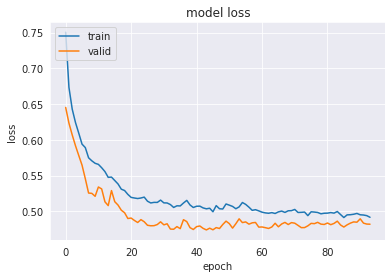

In [20]:
if nas:
    for trial in history: 
        print(trial.summary())
        
    writepath_nas = './results_nas.csv'

    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    

    if not os.path.exists(writepath_nas):
        with open(writepath_nas, 'w+') as text_file:       
            for key in flat_config.keys():
                text_file.write(key)
                text_file.write(';')         

            for hp in history[0].hyperparameters.values.keys():
                text_file.write(hp + ';')    
               
            text_file.write('score')
            
            text_file.write('\n')

    with open(writepath_nas, 'a+') as text_file:  
        for value in flat_config.values():
            text_file.write(str(value))
            text_file.write(';')

        for hp, value in history[0].hyperparameters.values.items():
            text_file.write(str(value) + ';')        

        
        text_file.write(str(history[0].score))
            
        text_file.write('\n')            

        text_file.close()      
        
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

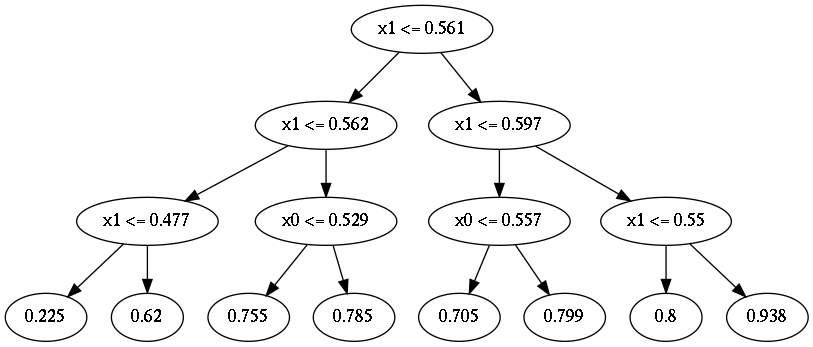

In [ ]:
index = 0
if test_size > 0:
    network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
else:
    network_parameters = np.array([lambda_net_dataset_valid.network_parameters_array[index]])
    
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data(network_parameters, config, encoder_model)    
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [ ]:
image = None
if not function_value_loss:
    if test_size > 0:
        dt_parameters = y_test[index][:-2 ** config['function_family']['maximum_depth'] ]
    else:
        dt_parameters = y_valid[index][:-2 ** config['function_family']['maximum_depth'] ]

    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
image

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 513)]        0                                            
__________________________________________________________________________________________________
hidden1_1792 (Dense)            (None, 1792)         921088      input[0][0]                      
__________________________________________________________________________________________________
activation1_sigmoid (Activation (None, 1792)         0           hidden1_1792[0][0]               
__________________________________________________________________________________________________
hidden2_512 (Dense)             (None, 512)          918016      activation1_sigmoid[0][0]        
______________________________________________________________________________________________

    Normal: This is useful for looking at means and other linear combinations (e.g. regression coefficients) because of the CLT. Related to that is if something is known to arise due to additive effects of many different small causes then the normal may be a reasonable distribution: for example, many biological measures are the result of multiple genes and multiple environmental factors and therefor are often approximately normal.

    Gamma: Right skewed and useful for things with a natural minimum at 0. Commonly used for elapsed times and some financial variables.

    Exponential: special case of the Gamma. It is memoryless and scales easily.

    Chi-squared (𝜒2): special case of the Gamma. Arises as sum of squared normal variables (so used for variances).

    Beta: Defined between 0 and 1 (but could be transformed to be between other values), useful for proportions or other quantities that must be between 0 and 1.

    Binomial: How many "successes" out of a given number of independent trials with same probability of "success".

    Poisson: Common for counts. Nice properties that if the number of events in a period of time or area follows a Poisson, then the number in twice the time or area still follows the Poisson (with twice the mean): this works for adding Poissons or scaling with values other than 2.

    Note that if events occur over time and the time between occurrences follows an exponential then the number that occur in a time period follows a Poisson.

    Negative Binomial: Counts with minimum 0 (or other value depending on which version) and no upper bound. Conceptually it is the number of "failures" before k "successes". The negative binomial is also a mixture of Poisson variables whose means come from a gamma distribution.

    Geometric: special case for negative binomial where it is the number of "failures" before the 1st "success". If you truncate (round down) an exponential variable to make it discrete, the result is geometric.

## Train & Valid Data Evaluation

In [ ]:

mean_train_parameters = np.round(np.mean(lambda_net_dataset_train.network_parameters_array, axis=0), 5)
std_train_parameters = np.round(np.std(lambda_net_dataset_train.network_parameters_array, axis=0), 5)

(inet_evaluation_result_dict_train, 
 inet_evaluation_result_dict_mean_train, 
 dt_distilled_list_train,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_train.network_parameters_array, 
                                                               lambda_net_dataset_train.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='train',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                               encoder_model=encoder_model)


(inet_evaluation_result_dict_valid, 
 inet_evaluation_result_dict_mean_valid, 
 dt_distilled_list_valid,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_valid.network_parameters_array, 
                                                               lambda_net_dataset_valid.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='valid',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                               distances_dict=distances_dict,
                                                               encoder_model=encoder_model)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:   11.0s remaining:  1.6min
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:   11.5s finished


  0%|          | 0/20 [00:00<?, ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    0.8s remaining:    7.0s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.9s finished


  0%|          | 0/20 [00:00<?, ?it/s]

## Test Data Evaluation (+ Distribution Evaluation)

In [ ]:
#%load_ext autoreload
#%autoreload 2
#set_loky_pickler('pickle')

In [ ]:
config['computation']['n_jobs'] = 60
config['i_net']['test_size'] = 10000

In [ ]:
if evaluate_distribution and test_size > 0:

    distrib_list = ['uniform', 'gamma', 'beta', 'poisson', 'normal']
    
    (distances_dict, 
     inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_complete_by_distribution_test,
     inet_evaluation_result_dict_mean_test,
     inet_evaluation_result_dict_mean_by_distribution_test,
     inet_evaluation_results_test, 
     dt_inet_list_test, 
     dt_distilled_list_test, 
     data_dict_list_test, 
     normalizer_list_list_test,
     test_network_list,
     model_history_list,
     distribution_parameter_list_list) = distribution_evaluation_interpretation_net_synthetic_data(loss_function, 
                                                                                            metrics,
                                                                                            #model,
                                                                                           config,
                                                                                           identifier='test',
                                                                                           lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array,
                                                                                           mean_train_parameters=mean_train_parameters,
                                                                                           std_train_parameters=std_train_parameters,
                                                                                           distances_dict=distances_dict,
                                                                                           max_distributions_per_class=max_distributions_per_class,#max_distributions_per_class,
                                                                                           flip_percentage=noise_injected_level, #0.1,#
                                                                                           data_noise=data_noise, #0.1,#
                                                                                           #encoder_model=encoder_model,                
                                                                                           distribution_list_generation = ['uniform', 'gamma', 'beta', 'poisson', 'normal'],#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'],
                                                                                           distribution_list_evaluation = distrib_list,#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'],
                                                                                           random_parameters = random_parameters_distribution, #random_parameters_distribution
                                                                                           verbose=0,
                                                                                           backend='loky',#sequential
                                                                                    )
else:
    (inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_mean_test, 
     dt_distilled_list_test,
     distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_test.network_parameters_array, 
                                                                   lambda_net_dataset_test.X_test_lambda_array,
                                                                   model,
                                                                   config,
                                                                   identifier='test',
                                                                   mean_train_parameters=mean_train_parameters,
                                                                   std_train_parameters=std_train_parameters,
                                                                   network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                                   distances_dict=distances_dict,
                                                                   encoder_model=encoder_model)
    
    print_results_synthetic_evaluation(inet_evaluation_result_dict_mean_train, 
                                       inet_evaluation_result_dict_mean_valid, 
                                       inet_evaluation_result_dict_mean_test, 
                                       distances_dict)    

UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE
UPDATE


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   8 tasks      | elapsed:   59.1s
[Parallel(n_jobs=60)]: Done 168 tasks      | elapsed:  4.4min
[Parallel(n_jobs=60)]: Done 392 tasks      | elapsed:  9.3min
[Parallel(n_jobs=60)]: Done 680 tasks      | elapsed: 15.4min
[Parallel(n_jobs=60)]: Done 1032 tasks      | elapsed: 23.2min
[Parallel(n_jobs=60)]: Done 1448 tasks      | elapsed: 31.7min
[Parallel(n_jobs=60)]: Done 1928 tasks      | elapsed: 41.6min
[Parallel(n_jobs=60)]: Done 2472 tasks      | elapsed: 53.1min
[Parallel(n_jobs=60)]: Done 3080 tasks      | elapsed: 66.1min
[Parallel(n_jobs=60)]: Done 3752 tasks      | elapsed: 80.2min
[Parallel(n_jobs=60)]: Done 4488 tasks      | elapsed: 95.8min
[Parallel(n_jobs=60)]: Done 5288 tasks      | elapsed: 113.0min
[Parallel(n_jobs=60)]: Done 6152 tasks      | elapsed: 131.6min
[Parallel(n_jobs=60)]: Done 7080 tasks      | elapsed: 151.5min


In [ ]:
#distribution_parameter_list_list[0]

In [ ]:
#lambda_net_dataset_valid.distribution_dict_list_list[0]

In [ ]:
distrib_list = ['uniform', 'gamma', 'beta', 'poisson', 'normal']

In [ ]:
inet_performance_distrib_evaluation = np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy'])
inet_performance_distrib_evaluation

In [ ]:
mean_random_performance_distrib_evaluation = np.mean(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in distrib_list]), axis=0)
mean_random_performance_distrib_evaluation

In [ ]:
max_random_performance_distrib_evaluation = np.max(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in distrib_list]), axis=0)
max_random_performance_distrib_evaluation

In [ ]:
print('Median I-Net:', np.median(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']))
print('Median DT Distilled:', np.median(np.median(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in distrib_list]), axis=0)))#np.median(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))


In [ ]:
complete_distribution_evaluation_results = get_complete_distribution_evaluation_results_dataframe(inet_evaluation_result_dict_mean_by_distribution_test)
complete_distribution_evaluation_results.head(20)

In [ ]:
network_distances = get_print_network_distances_dataframe(distances_dict)
network_distances.head(20)

In [ ]:
#index = 14
#index = np.argmax(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))
top_number = 0
#index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))[::-1][top_number]
distrib_list = ['uniform', 'gamma', 'beta', 'poisson', 'normal']
index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.max(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in distrib_list]), axis=0))[::-1][top_number]
#index = np.argsort(np.array(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']) - np.mean(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in distrib_list]), axis=0))[::-1][top_number]

distrib_for_index = np.argmax(np.array([inet_evaluation_result_dict_complete_by_distribution_test[distrib]['dt_scores']['accuracy'] for distrib in ['uniform', 'gamma', 'beta', 'poisson', 'normal']])[:,index])

print(index)

In [ ]:
distribution_parameter_list_list[index]

In [ ]:
if True:
    print(distribution_parameter_list_list[index])
    plot_decision_area_evaluation(data_dict_list_test[index]['X_train'], 
                                data_dict_list_test[index]['y_train'], 
                                data_dict_list_test[index]['X_test'], 
                                data_dict_list_test[index]['y_test'],
                                network_parameters_to_network(shaped_network_parameters_to_array(test_network_list[index], config), config),
                                dt_distilled_list_test[distrib_for_index][index][1],
                                dt_distilled_list_test[distrib_for_index][index][0],
                                dt_inet_list_test[distrib_for_index][index],
                                np.array([str(i) for i in range(data_dict_list_test[index]['X_train'].shape[1])]),
                                config
                               )

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    dt_inet = parameterDT(dt_inet_list_test[distrib_for_index][index], config)
    image = dt_inet.plot()
    #image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    dt_parameters = dt_inet_list_test[distrib_for_index][index]
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(25,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][0], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
    image = plt.show()
else:
    image = dt_distilled_list_test[distrib_for_index][index][0].plot_tree()
image

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(25,8))
    plot_tree(dt_distilled_list_test[distrib_for_index][index][1], fontsize=10)  #fist index=distrib; second index=index; third index=10k vs Train
    image = plt.show()
else:
    image = dt_distilled_list_test[distrib_for_index][index][0].plot_tree()
image

In [ ]:
if False:
    number = 6

    X_data, y_data, distribution_parameter_list, normalizer_list = generate_dataset_from_distributions(['uniform'],# ['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'], 
                                          number, 
                                          10000,
                                          distributions_per_class = 1, 
                                          seed=41,
                                          flip_percentage=0,
                                          config=config)

    rand = np.random.RandomState(42)    

    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    fig,ax = plt.subplots(nrows=3, ncols=4,figsize=(25,10))
    plot_index = 0

    for i,(colors, distribution_parameter) in enumerate(zip(colors_list[:number], distribution_parameter_list[:number])):
        print(distribution_parameter)

        x = X_data[:,i][np.where(y_data==0)]
        plt.subplot(3,4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
        plot_index += 1

        x = X_data[:,i][np.where(y_data==1)]
        plt.subplot(3,4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
        plot_index += 1

    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()


In [ ]:
lambda_net_dataset_valid.distribution_dict_list_list[index]

In [ ]:
if True:
    #index = 0
    test_network = network_parameters_to_network(lambda_net_dataset_valid.network_parameters_array[index], config, base_model=None)
    distribution_dict = lambda_net_dataset_valid.distribution_dict_list_list[index]

    X_test = lambda_net_dataset_valid.X_test_lambda_array[index]#generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'], categorical_indices=None, distrib=config['evaluation']['random_evaluation_dataset_distribution'])


    distribution_training = distrib_list[distrib_for_index]#'uniform'

    evaluation_result_dict, results_list, test_network_parameters, dt_inet, dt_distilled_list = evaluate_network_real_world_data(model,
                                                                                                test_network, 
                                                                                                _, 
                                                                                                X_test, 
                                                                                                dataset_size_list=[10000],
                                                                                                config=config,
                                                                                                distribution=distribution_training)


    results_list_extended = results_list[0]

    results_list = results_list_extended
    evaluation_result_dict = results_list

    test_network_parameters = test_network_parameters#[:1]
    dt_inet = dt_inet#[:1]
    dt_distilled_list = dt_distilled_list#[:1]

    print(evaluation_result_dict)
    
    print('Class 0: ', test_network.predict(X_test[np.where(test_network.predict(X_test).ravel()<0.5)]).shape[0])
    print('Class 1: ', test_network.predict(X_test[np.where(test_network.predict(X_test).ravel()>=0.5)]).shape[0])    
    
    ############################################################################################################################################
    ############################################################################################################################################
    
    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    if config['data']['number_of_variables'] > 4:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
    else:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))

    for axis_1 in ax:
        for axis_2 in axis_1:
            axis_2.set_xlim([0, 1])                          
    
    plot_index = 0

    for i in range(X_test.shape[1]):
        try:
            distribution_parameter = distribution_dict[i]
            print(distribution_parameter)
        except:
            pass
        colors = colors_list[i%6]

        x = X_test[:,i][np.where(test_network.predict(X_test).ravel()<=0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        try:
            plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
        except:
            pass            
        plot_index += 1

        x = X_test[:,i][np.where(test_network.predict(X_test).ravel()>0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int),4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        try:
            plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
        except:
            pass        
        plot_index += 1

    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()

In [ ]:
if True:
    #index = 0
    test_network = network_parameters_to_network(shaped_network_parameters_to_array(test_network_list[index], config), config, base_model=None)
    
    distribution_dict = distribution_parameter_list_list[index] 

    X_test = data_dict_list_test[0]['X_test']#generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'], categorical_indices=None, distrib=config['evaluation']['random_evaluation_dataset_distribution'])


    distribution_training = distrib_list[distrib_for_index]#'uniform'

    evaluation_result_dict, results_list, test_network_parameters, dt_inet, dt_distilled_list = evaluate_network_real_world_data(model,
                                                                                                test_network, 
                                                                                                _, 
                                                                                                X_test, 
                                                                                                dataset_size_list=[10000],
                                                                                                config=config,
                                                                                                distribution=distribution_training)


    results_list_extended = results_list[0]

    results_list = results_list_extended
    evaluation_result_dict = results_list

    test_network_parameters = test_network_parameters#[:1]
    dt_inet = dt_inet#[:1]
    dt_distilled_list = dt_distilled_list#[:1]

    print(evaluation_result_dict)
    
    try:
        print('Class 0: ', test_network.predict(X_test[np.where(test_network.predict(X_test).ravel()<0.5)]).shape[0])
        print('Class 1: ', test_network.predict(X_test[np.where(test_network.predict(X_test).ravel()>=0.5)]).shape[0])
    except:
        pass
        
    ############################################################################################################################################
    ############################################################################################################################################
    
    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    if config['data']['number_of_variables'] > 4:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
    else:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))

    
    for axis_1 in ax:
        for axis_2 in axis_1:
            axis_2.set_xlim([0, 1])                          
    
    plot_index = 0

    for i in range(X_test.shape[1]):
        try:
            distribution_parameter = distribution_dict[i]
            print(distribution_parameter)
        except:
            pass             
        colors = colors_list[i%6]

        x = X_test[:,i][np.where(test_network.predict(X_test).ravel()<=0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        try:
            plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
        except:
            pass                 
        plot_index += 1

        x = X_test[:,i][np.where(test_network.predict(X_test).ravel()>0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        try:
            plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
        except:
            pass                 
        plot_index += 1

    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()    

### Distribution Evaluation (Selected Samples)

In [ ]:
%load_ext autoreload
%autoreload 2
evaluate_network_on_distribution_custom_parameters(distribution_name_feature_0 = 'normal',
                                                   distribution_name_feature_1 = 'normal',
                                                   distribution_parameters_0_param_1_feature_0 = 1.188840288782265,
                                                   distribution_parameters_0_param_2_feature_0 = 0.8566173698593895,
                                                   distribution_parameters_1_param_1_feature_0 = 0.8713650102755661,
                                                   distribution_parameters_1_param_2_feature_0 = 1.8484540179178748,
                                                   distribution_parameters_0_param_1_feature_1 = 1.7185974826882278,
                                                   distribution_parameters_0_param_2_feature_1 = 0.5807878500034862,
                                                   distribution_parameters_1_param_1_feature_1 = 0.44369536008631294,
                                                   distribution_parameters_1_param_2_feature_1 = 1.17864258666672,
                                                   inet = model,
                                                   config = config)

# Real-World Data Evaluation

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
dataset_size_list = [10_000, 'TRAIN_DATA']#[1_000, 10_000, 100_000, 1_000_000, 'TRAIN_DATA']
dataset_size_list_print = []
for size in dataset_size_list:
    if type(size) is int:
        size = size//1000
        size = str(size) + 'k'
        dataset_size_list_print.append(size)
    else:
        dataset_size_list_print.append(size)

In [ ]:
#distances_dict = {}
evaluation_result_dict = {}
results_dict = {}
dt_inet_dict = {}
dt_distilled_list_dict = {}
data_dict = {}
normalizer_list_dict = {}
test_network_list = {}

identifier_list = []


## Adult Dataset

In [ ]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 

adult_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)


#adult_data['Workclass'][adult_data['Workclass'] != ' Private'] = 'Other'
#adult_data['Race'][adult_data['Race'] != ' White'] = 'Other'

#adult_data.head()

features_select = [
                 "Sex",  #9 
                 "Race",  #8
                 "Workclass",  #1
                 "Age", #0
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 #"Country", #13 
                 "capital_gain"
                  ]

adult_data = adult_data[features_select]

nominal_features_adult = ['Race', 'Workclass', 'Education', "Marital Status", "Occupation", "Relationship"]
ordinal_features_adult = ['Sex']

X_data_adult = adult_data.drop(['capital_gain'], axis = 1)

#y_data_adult = pd.Series(OrdinalEncoder().fit_transform(adult_data['capital_gain'].values.reshape(-1, 1)).flatten(), name='capital_gain')
y_data_adult = ((adult_data['capital_gain'] != ' <=50K') * 1)

In [ ]:
config_train_network_adult = deepcopy(config)
#config_train_network_adult['lambda_net']['batch_lambda'] = 32
#config_train_network_adult['lambda_net']['learning_rate_lambda'] = 0.0003
#config_train_network_adult['lambda_net']['dropout_lambda'] = 0.25
#config_train_network_adult['lambda_net']['epochs_lambda'] = 5

In [ ]:
identifier = 'Adult'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_adult, 
                                                                y_data_adult, 
                                                                nominal_features = nominal_features_adult, 
                                                                ordinal_features = ordinal_features_adult,
                                                                config = config,
                                                                config_train_network = config_train_network_adult)

print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict['Adult'], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

In [ ]:
evaluation_result_dict

## Titanic Dataset

In [ ]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)

features_select = [
                    #'Cabin', 
                    #'Ticket', 
                    #'Name', 
                    #'PassengerId'    
                    'Sex',    
                    'Embarked',
                    'Pclass',
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    'Survived',    
                  ]

titanic_data = titanic_data[features_select]

nominal_features_titanic = ['Embarked']#[1, 2, 7]
ordinal_features_titanic = ['Sex']
    
X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']


    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
identifier = 'Titanic'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_titanic, 
                                                                y_data_titanic, 
                                                                nominal_features = nominal_features_titanic, 
                                                                ordinal_features = ordinal_features_titanic,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

## Absenteeism at Work Dataset

In [ ]:
absenteeism_data = pd.read_csv('real_world_datasets/Absenteeism/absenteeism.csv', delimiter=';')

features_select = [
                           'Disciplinary failure', #CATEGORICAL
                           'Social drinker', #CATEGORICAL
                           'Social smoker', #CATEGORICAL
                           'Transportation expense', 
                           'Distance from Residence to Work',
                           'Service time', 
                           'Age', 
                           'Work load Average/day ', 
                           'Hit target',
                           'Education', 
                           'Son', 
                           'Pet', 
                           'Weight', 
                           'Height', 
                           'Body mass index', 
                           'Absenteeism time in hours'
                        ]

absenteeism_data = absenteeism_data[features_select]

nominal_features_absenteeism = []
ordinal_features_absenteeism = []
    
X_data_absenteeism = absenteeism_data.drop(['Absenteeism time in hours'], axis = 1)
y_data_absenteeism = ((absenteeism_data['Absenteeism time in hours'] > 4) * 1) #absenteeism_data['Absenteeism time in hours']


    3. Month of absence
    4. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
    5. Seasons (summer (1), autumn (2), winter (3), spring (4))
    6. Transportation expense
    7. Distance from Residence to Work (kilometers)
    8. Service time
    9. Age
    10. Work load Average/day
    11. Hit target
    12. Disciplinary failure (yes=1; no=0)
    13. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
    14. Son (number of children)
    15. Social drinker (yes=1; no=0)
    16. Social smoker (yes=1; no=0)
    17. Pet (number of pet)
    18. Weight
    19. Height
    20. Body mass index
    21. Absenteeism time in hours (target)

In [ ]:
identifier = 'Absenteeism'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_absenteeism, 
                                                                y_data_absenteeism, 
                                                                nominal_features = nominal_features_absenteeism, 
                                                                ordinal_features = ordinal_features_absenteeism,
                                                                config = config,
                                                                config_train_network = None)

print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

## Loan House

In [ ]:
loan_data = pd.read_csv('real_world_datasets/Loan/loan-train.csv', delimiter=',')

loan_data['Gender'].fillna(loan_data['Gender'].mode()[0], inplace=True)
loan_data['Dependents'].fillna(loan_data['Dependents'].mode()[0], inplace=True)
loan_data['Married'].fillna(loan_data['Married'].mode()[0], inplace=True)
loan_data['Self_Employed'].fillna(loan_data['Self_Employed'].mode()[0], inplace=True)
loan_data['LoanAmount'].fillna(loan_data['LoanAmount'].mean(), inplace=True)
loan_data['Loan_Amount_Term'].fillna(loan_data['Loan_Amount_Term'].mean(), inplace=True)
loan_data['Credit_History'].fillna(loan_data['Credit_History'].mean(), inplace=True)

features_select = [
                    #'Loan_ID', 
                    'Gender', #
                    'Married', 
                    'Dependents', 
                    'Education',
                    'Self_Employed', 
                    'ApplicantIncome', 
                    'CoapplicantIncome', 
                    'LoanAmount',
                    'Loan_Amount_Term', 
                    'Credit_History', 
                    'Property_Area', 
                    'Loan_Status'
                    ]

loan_data = loan_data[features_select]

loan_data['Dependents'][loan_data['Dependents'] == '3+'] = 4
loan_data['Dependents'] = loan_data['Dependents'].astype(int)

loan_data['Property_Area'][loan_data['Property_Area'] == 'Rural'] = 0
loan_data['Property_Area'][loan_data['Property_Area'] == 'Semiurban'] = 1
loan_data['Property_Area'][loan_data['Property_Area'] == 'Urban'] = 2
loan_data['Property_Area'] = loan_data['Property_Area'].astype(int)

nominal_features_loan = [
                        #'Dependents',
                        #'Property_Area',    
                        ]


ordinal_features_loan = [
                    'Education',
                    'Gender', 
                    'Married', 
                    'Self_Employed',
                   ]
    
X_data_loan = loan_data.drop(['Loan_Status'], axis = 1)
y_data_loan = ((loan_data['Loan_Status'] == 'Y') * 1) 

In [ ]:
config_train_network_loan_house = deepcopy(config)
#config_train_network_loan_house['lambda_net']['batch_lambda'] = 64#16
#config_train_network_loan_house['lambda_net']['learning_rate_lambda'] = 0.001
#config_train_network_loan_house['lambda_net']['dropout_lambda'] = 0#.1
#config_train_network_loan_house['lambda_net']['epochs_lambda'] = 500
#config_train_network_loan_house['lambda_net']['optimizer_lambda'] = 'adam'


In [ ]:
identifier = 'Loan House'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_loan, 
                                                                y_data_loan, 
                                                                nominal_features = nominal_features_loan, 
                                                                ordinal_features = ordinal_features_loan,
                                                                #config = config_train_network_loan_house,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

In [ ]:
if False:

    X_test = data_dict['Loan House']['X_train'].values#data_dict_list_test[0]['X_test']#generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'], categorical_indices=None, distrib=config['evaluation']['random_evaluation_dataset_distribution'])
    y_test = data_dict['Loan House']['y_train'].values
    
    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    if config['data']['number_of_variables'] > 4:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
    else:
        fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))    
    
    for axis_1 in ax:
        for axis_2 in axis_1:
            axis_2.set_xlim([0, 1])                          
    
    plot_index = 0

    for i in range(X_test.shape[1]):
        #distribution_parameter = distribution_dict[i]
        #print(distribution_parameter)
        colors = colors_list[i%6]

        x = X_test[:,i][np.where(y_test.ravel()<=0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        #plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
        plot_index += 1

        x = X_test[:,i][np.where(y_test.ravel()>0.5)]
        plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
        plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
        #plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
        plot_index += 1

    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()    

## Loan Credit

In [ ]:
loan_credit_data = pd.read_csv('real_world_datasets/Credit Loan/train_split.csv', delimiter=',')

loan_credit_data['emp_title'].fillna(loan_credit_data['emp_title'].mode()[0], inplace=True)
loan_credit_data['emp_length'].fillna(loan_credit_data['emp_length'].mode()[0], inplace=True)
#loan_credit_data['desc'].fillna(loan_credit_data['desc'].mode()[0], inplace=True)
loan_credit_data['title'].fillna(loan_credit_data['title'].mode()[0], inplace=True)
#loan_credit_data['mths_since_last_delinq'].fillna(loan_credit_data['mths_since_last_delinq'].mode()[0], inplace=True)
#loan_credit_data['mths_since_last_record'].fillna(loan_credit_data['mths_since_last_record'].mode()[0], inplace=True)
loan_credit_data['revol_util'].fillna(loan_credit_data['revol_util'].mode()[0], inplace=True)
loan_credit_data['collections_12_mths_ex_med'].fillna(loan_credit_data['collections_12_mths_ex_med'].mode()[0], inplace=True)
#loan_credit_data['mths_since_last_major_derog'].fillna(loan_credit_data['mths_since_last_major_derog'].mode()[0], inplace=True)
#loan_credit_data['verification_status_joint'].fillna(loan_credit_data['verification_status_joint'].mode()[0], inplace=True)
loan_credit_data['tot_coll_amt'].fillna(loan_credit_data['tot_coll_amt'].mode()[0], inplace=True)
loan_credit_data['tot_cur_bal'].fillna(loan_credit_data['tot_cur_bal'].mode()[0], inplace=True)
loan_credit_data['total_rev_hi_lim'].fillna(loan_credit_data['total_rev_hi_lim'].mode()[0], inplace=True)


##remove too many null
#'mths_since_last_delinq','mths_since_last_record', 'mths_since_last_major_derog','pymnt_plan','desc', 'verification_status_joint'


features_select = [
                    #'member_id', 
                    'loan_amnt', 
                    'funded_amnt', 
                    'funded_amnt_inv', 
                    'term',
                    #'batch_enrolled',
                    'int_rate', 
                    'grade', 
                    #'sub_grade', 
                    #'emp_title',
                    'emp_length',
                    'home_ownership', 
                    'annual_inc', 
                    'verification_status',
                    #'pymnt_plan', 
                    #'desc', 
                    'purpose', 
                    'title', 
                    #'zip_code', 
                    #'addr_state',
                    'dti', 
                    'delinq_2yrs', 
                    'inq_last_6mths', 
                    #'mths_since_last_delinq',
                    #'mths_since_last_record',
                    'open_acc', 
                    'pub_rec', 
                    'revol_bal',
                    'revol_util', 
                    'total_acc', 
                    'initial_list_status', 
                    'total_rec_int',
                    'total_rec_late_fee', 
                    'recoveries', 
                    'collection_recovery_fee',
                    'collections_12_mths_ex_med', 
                    #'mths_since_last_major_derog',
                    'application_type', 
                    #'verification_status_joint', 
                    'last_week_pay',
                    'acc_now_delinq', 
                    'tot_coll_amt', 
                    'tot_cur_bal', 
                    'total_rev_hi_lim',
                    'loan_status'
                    ]

loan_credit_data = loan_credit_data[features_select]

nominal_features_loan_credit = [

                        ]
ordinal_features_loan_credit = [
                    #'member_id', 
                    'loan_amnt', 
                    'funded_amnt', 
                    'funded_amnt_inv', 
                    'term',
                    #'batch_enrolled',
                    'int_rate', 
                    'grade', 
                    #'sub_grade', 
                    #'emp_title',
                    'emp_length',
                    'home_ownership', 
                    'annual_inc', 
                    'verification_status',
                    #'pymnt_plan', 
                    #'desc', 
                    'purpose', 
                    'title', 
                    #'zip_code', 
                    #'addr_state',
                    'dti', 
                    'delinq_2yrs', 
                    'inq_last_6mths', 
                    #'mths_since_last_delinq',
                    #'mths_since_last_record',
                    'open_acc', 
                    'pub_rec', 
                    'revol_bal',
                    'revol_util', 
                    'total_acc', 
                    'initial_list_status', 
                    'total_rec_int',
                    'total_rec_late_fee', 
                    'recoveries', 
                    'collection_recovery_fee',
                    'collections_12_mths_ex_med', 
                    #'mths_since_last_major_derog',
                    'application_type', 
                    #'verification_status_joint', 
                    'last_week_pay',
                    'acc_now_delinq', 
                    'tot_coll_amt', 
                    'tot_cur_bal', 
                    'total_rev_hi_lim',
                   ]
    
X_data_loan_credit = loan_credit_data.drop(['loan_status'], axis = 1)
y_data_loan_credit = pd.Series(OrdinalEncoder().fit_transform(loan_credit_data['loan_status'].values.reshape(-1, 1)).flatten(), name='loan_status')


In [ ]:
identifier = 'Loan Credit'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_loan_credit, 
                                                                y_data_loan_credit, 
                                                                nominal_features = nominal_features_loan_credit, 
                                                                ordinal_features = ordinal_features_loan_credit,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

## Medical Insurance

In [ ]:
medical_insurance_data = pd.read_csv('real_world_datasets/Medical Insurance/insurance.csv', delimiter=',')

features_select = [
                    'age', 
                    'sex', 
                    'bmi', 
                    'children', 
                    'smoker',
                    'region',
                    'charges'
                    ]

medical_insurance_data = medical_insurance_data[features_select]

nominal_features_medical_insurance = [

                        ]
ordinal_features_medical_insurance = [
                    'sex',
                    'region',
                    'smoker'
                   ]

    
X_data_medical_insurance = medical_insurance_data.drop(['charges'], axis = 1)
y_data_medical_insurance = ((medical_insurance_data['charges'] > 10_000) * 1)


print(X_data_medical_insurance.shape)
X_data_medical_insurance.head()


In [ ]:
identifier = 'Medical Insurance'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_medical_insurance, 
                                                                y_data_medical_insurance, 
                                                                nominal_features = nominal_features_medical_insurance, 
                                                                ordinal_features = ordinal_features_medical_insurance,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

## Bank Marketing

In [ ]:
bank_data = pd.read_csv('real_world_datasets/Bank Marketing/bank-full.csv', delimiter=';') #bank

features_select = [
                    'age',
                    #'job', 
                    'marital', 
                    'education', 
                    'default',
                    'housing',
                    'loan',
                    #'contact',
                    #'day',
                    #'month',
                    'duration',
                    'campaign',
                    'pdays',
                    'previous',
                    'poutcome',
                    'y',
                    ]

bank_data = bank_data[features_select]

nominal_features_bank = [
                        #'job',
                        'education',
                        #'contact',
                        #'day',
                        #'month',
                        'poutcome',
                        ]
ordinal_features_bank = [
                    'marital',
                    'default',
                    'housing',
                    'loan',
                   ]

    
X_data_bank = bank_data.drop(['y'], axis = 1)
y_data_bank = pd.Series(OrdinalEncoder().fit_transform(bank_data['y'].values.reshape(-1, 1)).flatten(), name='y')


In [ ]:
identifier = 'Bank Marketing'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_bank, 
                                                                y_data_bank, 
                                                                nominal_features = nominal_features_bank, 
                                                                ordinal_features = ordinal_features_bank,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

## Cervical cancer (Risk Factors) Data Set

In [ ]:
cc_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv', index_col=False)#, names=feature_names

features_select = [
                    'Age',
                    'Number of sexual partners',
                    'First sexual intercourse',
                    'Num of pregnancies',
                    'Smokes',
                    'Smokes (years)',
                    'Hormonal Contraceptives',
                    'Hormonal Contraceptives (years)',
                    'IUD',
                    'IUD (years)',
                    'STDs',
                    'STDs (number)',
                    'STDs: Number of diagnosis',
                    'STDs: Time since first diagnosis',
                    'STDs: Time since last diagnosis',
                    'Biopsy'
                    ]

cc_data = cc_data[features_select]

cc_data['Number of sexual partners'][cc_data['Number of sexual partners'] == '?'] = cc_data['Number of sexual partners'].mode()[0]
cc_data['First sexual intercourse'][cc_data['First sexual intercourse'] == '?'] = cc_data['First sexual intercourse'].mode()[0]
cc_data['Num of pregnancies'][cc_data['Num of pregnancies'] == '?'] = cc_data['Num of pregnancies'].mode()[0]
cc_data['Smokes'][cc_data['Smokes'] == '?'] = cc_data['Smokes'].mode()[0]
cc_data['Smokes (years)'][cc_data['Smokes (years)'] == '?'] = cc_data['Smokes (years)'].mode()[0]
cc_data['Hormonal Contraceptives'][cc_data['Hormonal Contraceptives'] == '?'] = cc_data['Hormonal Contraceptives'].mode()[0]
cc_data['Hormonal Contraceptives (years)'][cc_data['Hormonal Contraceptives (years)'] == '?'] = cc_data['Hormonal Contraceptives (years)'].mode()[0]
cc_data['IUD'][cc_data['IUD'] == '?'] = cc_data['IUD'].mode()[0]
cc_data['IUD (years)'][cc_data['IUD (years)'] == '?'] = cc_data['IUD (years)'].mode()[0]
cc_data['STDs'][cc_data['STDs'] == '?'] = cc_data['STDs'].mode()[0]
cc_data['STDs (number)'][cc_data['STDs (number)'] == '?'] = cc_data['STDs (number)'].mode()[0]
cc_data['STDs: Time since first diagnosis'][cc_data['STDs: Time since first diagnosis'] == '?'] = cc_data['STDs: Time since first diagnosis'][cc_data['STDs: Time since first diagnosis'] != '?'].mode()[0]
cc_data['STDs: Time since last diagnosis'][cc_data['STDs: Time since last diagnosis'] == '?'] = cc_data['STDs: Time since last diagnosis'][cc_data['STDs: Time since last diagnosis'] != '?'].mode()[0]

nominal_features_cc = [
                        ]
ordinal_features_cc = [
                   ]

    
X_data_cc = cc_data.drop(['Biopsy'], axis = 1)
y_data_cc = pd.Series(OrdinalEncoder().fit_transform(cc_data['Biopsy'].values.reshape(-1, 1)).flatten(), name='Biopsy')


In [ ]:
identifier = 'Cervical Cancer'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_cc, 
                                                                y_data_cc, 
                                                                nominal_features = nominal_features_cc, 
                                                                ordinal_features = ordinal_features_cc,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

## Brest Cancer Wisconsin

In [ ]:
feature_names = [
                'Sample code number',
                'Clump Thickness',
                'Uniformity of Cell Size',
                'Uniformity of Cell Shape',
                'Marginal Adhesion',
                'Single Epithelial Cell Size',
                'Bare Nuclei',
                'Bland Chromatin',
                'Normal Nucleoli',
                'Mitoses',
                'Class',
                ]

bcw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', names=feature_names, index_col=False)

bcw_data['Clump Thickness'][bcw_data['Clump Thickness'] == '?'] = bcw_data['Clump Thickness'].mode()[0]
bcw_data['Uniformity of Cell Size'][bcw_data['Uniformity of Cell Size'] == '?'] = bcw_data['Uniformity of Cell Size'].mode()[0]
bcw_data['Uniformity of Cell Shape'][bcw_data['Uniformity of Cell Shape'] == '?'] = bcw_data['Uniformity of Cell Shape'].mode()[0]
bcw_data['Marginal Adhesion'][bcw_data['Marginal Adhesion'] == '?'] = bcw_data['Marginal Adhesion'].mode()[0]
bcw_data['Single Epithelial Cell Size'][bcw_data['Single Epithelial Cell Size'] == '?'] = bcw_data['Single Epithelial Cell Size'].mode()[0]
bcw_data['Bare Nuclei'][bcw_data['Bare Nuclei'] == '?'] = bcw_data['Bare Nuclei'].mode()[0]
bcw_data['Bland Chromatin'][bcw_data['Bland Chromatin'] == '?'] = bcw_data['Bland Chromatin'].mode()[0]
bcw_data['Normal Nucleoli'][bcw_data['Normal Nucleoli'] == '?'] = bcw_data['Normal Nucleoli'].mode()[0]
bcw_data['Mitoses'][bcw_data['Mitoses'] == '?'] = bcw_data['Mitoses'].mode()[0]

features_select = [
                #'Sample code number',
                'Clump Thickness',
                'Uniformity of Cell Size',
                'Uniformity of Cell Shape',
                'Marginal Adhesion',
                'Single Epithelial Cell Size',
                'Bare Nuclei',
                'Bland Chromatin',
                'Normal Nucleoli',
                'Mitoses',
                'Class',
                    ]

bcw_data = bcw_data[features_select]

nominal_features_bcw = [
                        ]
ordinal_features_bcw = [
                   ]

    
X_data_bcw = bcw_data.drop(['Class'], axis = 1)
y_data_bcw = pd.Series(OrdinalEncoder().fit_transform(bcw_data['Class'].values.reshape(-1, 1)).flatten(), name='Class')


In [ ]:
identifier = 'Brest Cancer Wisconsin'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_bcw, 
                                                                y_data_bcw, 
                                                                nominal_features = nominal_features_bcw, 
                                                                ordinal_features = ordinal_features_bcw,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

## Wisconsin Diagnostic Breast Cancer

In [ ]:
feature_names = [
                'ID number',
                'Diagnosis',
                'radius',# (mean of distances from center to points on the perimeter)
                'texture',# (standard deviation of gray-scale values)
                'perimeter',
                'area',
                'smoothness',# (local variation in radius lengths)
                'compactness',# (perimeter^2 / area - 1.0)
                'concavity',# (severity of concave portions of the contour)
                'concave points',# (number of concave portions of the contour)
                'symmetry',
                'fractal dimension',# ("coastline approximation" - 1)
                ]
#Wisconsin Diagnostic Breast Cancer
wdbc_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', names=feature_names, index_col=False)

features_select = [
                    #'ID number',
                    'Diagnosis',
                    'radius',# (mean of distances from center to points on the perimeter)
                    'texture',# (standard deviation of gray-scale values)
                    'perimeter',
                    'area',
                    'smoothness',# (local variation in radius lengths)
                    'compactness',# (perimeter^2 / area - 1.0)
                    'concavity',# (severity of concave portions of the contour)
                    'concave points',# (number of concave portions of the contour)
                    'symmetry',
                    'fractal dimension',# ("coastline approximation" - 1)
                    ]

wdbc_data = wdbc_data[features_select]

nominal_features_wdbc = [
                        ]
ordinal_features_wdbc = [
                   ]

    
X_data_wdbc = wdbc_data.drop(['Diagnosis'], axis = 1)
y_data_wdbc= pd.Series(OrdinalEncoder().fit_transform(wdbc_data['Diagnosis'].values.reshape(-1, 1)).flatten(), name='Diagnosis')


In [ ]:
identifier = 'Wisconsin Diagnostic Breast Cancer'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_wdbc, 
                                                                y_data_wdbc, 
                                                                nominal_features = nominal_features_wdbc, 
                                                                ordinal_features = ordinal_features_wdbc,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

## Wisconsin Prognostic Breast Cancer

In [ ]:
feature_names = [
                'ID number',
                'Diagnosis',
                'radius',# (mean of distances from center to points on the perimeter)
                'texture',# (standard deviation of gray-scale values)
                'perimeter',
                'area',
                'smoothness',# (local variation in radius lengths)
                'compactness',# (perimeter^2 / area - 1.0)
                'concavity',# (severity of concave portions of the contour)
                'concave points',# (number of concave portions of the contour)
                'symmetry',
                'fractal dimension',# ("coastline approximation" - 1)
                ]
#Wisconsin Prognostic Breast Cancer
wpbc_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data', names=feature_names, index_col=False)

features_select = [
                    #'ID number',
                    'Diagnosis',
                    'radius',# (mean of distances from center to points on the perimeter)
                    'texture',# (standard deviation of gray-scale values)
                    'perimeter',
                    'area',
                    'smoothness',# (local variation in radius lengths)
                    'compactness',# (perimeter^2 / area - 1.0)
                    'concavity',# (severity of concave portions of the contour)
                    'concave points',# (number of concave portions of the contour)
                    'symmetry',
                    'fractal dimension',# ("coastline approximation" - 1)
                    ]

wpbc_data = wpbc_data[features_select]

nominal_features_wpbc = [
                        ]
ordinal_features_wpbc = [
                   ]
 
X_data_wpbc = wpbc_data.drop(['Diagnosis'], axis = 1)
y_data_wpbc= pd.Series(OrdinalEncoder().fit_transform(wpbc_data['Diagnosis'].values.reshape(-1, 1)).flatten(), name='Diagnosis')


In [ ]:
identifier = 'Wisconsin Prognostic Breast Cancer'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_wpbc, 
                                                                y_data_wpbc, 
                                                                nominal_features = nominal_features_wpbc, 
                                                                ordinal_features = ordinal_features_wpbc,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

## Abalone

In [ ]:
feature_names = [
                'Sex',#		nominal			M, F, and I (infant)
                'Length',#	continuous	mm	Longest shell measurement
                'Diameter',#	continuous	mm	perpendicular to length
                'Height',#		continuous	mm	with meat in shell
                'Whole weight',#	continuous	grams	whole abalone
                'Shucked weight',#	continuous	grams	weight of meat
                'Viscera weight',#	continuous	grams	gut weight (after bleeding)
                'Shell weight',#	continuous	grams	after being dried
                'Rings',#		integer			+1.5 gives the age in years
                ]

abalone_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', names=feature_names, index_col=False)


features_select = [
                'Sex',#		nominal			M, F, and I (infant)
                'Length',#	continuous	mm	Longest shell measurement
                'Diameter',#	continuous	mm	perpendicular to length
                'Height',#		continuous	mm	with meat in shell
                'Whole weight',#	continuous	grams	whole abalone
                'Shucked weight',#	continuous	grams	weight of meat
                'Viscera weight',#	continuous	grams	gut weight (after bleeding)
                'Shell weight',#	continuous	grams	after being dried
                'Rings',#		integer			+1.5 gives the age in years
                    ]

abalone_data = abalone_data[features_select]

nominal_features_abalone = [
                        'Sex',
                        ]
ordinal_features_abalone = [
                   ]
   
X_data_abalone = abalone_data.drop(['Rings'], axis = 1)
y_data_abalone = ((abalone_data['Rings'] > 10) * 1)
    

In [ ]:
identifier = 'Abalone'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_abalone, 
                                                                y_data_abalone, 
                                                                nominal_features = nominal_features_abalone, 
                                                                ordinal_features = ordinal_features_abalone,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

## Car

In [ ]:
feature_names = [
   'buying',#       v-high, high, med, low
   'maint',#        v-high, high, med, low
   'doors',#        2, 3, 4, 5-more
   'persons',#      2, 4, more
   'lug_boot',#     small, med, big
   'safety',#       low, med, high
   'class',#        unacc, acc, good, v-good
                ]

car_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=feature_names, index_col=False)

features_select = [
                   'buying',#       v-high, high, med, low
                   'maint',#        v-high, high, med, low
                   'doors',#        2, 3, 4, 5-more
                   'persons',#      2, 4, more
                   'lug_boot',#     small, med, big
                   'safety',#       low, med, high
                   'class',#        unacc, acc, good, v-good
                    ]

car_data = car_data[features_select]

nominal_features_car = [
                       'buying',#       v-high, high, med, low
                       'maint',#        v-high, high, med, low
                       'doors',#        2, 3, 4, 5-more
                       'persons',#      2, 4, more
                       'lug_boot',#     small, med, big
                       'safety',#       low, med, high
                        ]

ordinal_features_car = [
                   ]


    
X_data_car = car_data.drop(['class'], axis = 1)
y_data_car = ((car_data['class'] != 'unacc') * 1)

In [ ]:
identifier = 'Car'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier],
 test_network_list[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_car, 
                                                                y_data_car, 
                                                                nominal_features = nominal_features_car, 
                                                                ordinal_features = ordinal_features_car,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

In [ ]:
if True:
    plot_decision_area_evaluation(data_dict[identifier]['X_train'].values, 
                                data_dict[identifier]['y_train'].values, 
                                data_dict[identifier]['X_test'].values, 
                                data_dict[identifier]['y_test'].values,
                                test_network_list[identifier],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index('TRAIN_DATA')],
                                dt_distilled_list_dict[identifier][0][dataset_size_list.index(10_000)],
                                dt_inet_dict[identifier],
                                data_dict[identifier]['X_train'].columns,
                                config
                               )

# Plot and Save Results

In [ ]:

def get_complete_performance_evaluation_results_dataframe(results_dict, identifier_list, dataset_size_list, dataset_size=10000):

    columns=[
             'Acc Distilled (Train Data)', 
             'Acc Distilled', 
             'Acc Distilled STD', 
             'Acc I-Net',   
             'Soft BC Distilled (Train Data)', 
             'Soft BC Distilled', 
             'Soft BC Distilled STD', 
             'Soft BC I-Net', 
             'BC Distilled (Train Data)', 
             'BC Distilled', 
             'BC Distilled STD', 
             'BC I-Net', 
             'F1 Score Distilled (Train Data)', 
             'F1 Score Distilled', 
             'F1 Score Distilled STD', 
             'F1 Score I-Net', 
             'Runtime Distilled (Train Data)', 
             'Runtime Distilled', 
             'Runtime Distilled STD', 
             'Runtime I-Net']    
    #index = [] #'Metric'
    print(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['accuracy'])
    
    data = np.array([
                      [[
                          np.round(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['accuracy'], 3),
                          #np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['accuracy_data_random']
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['accuracy'], 3),
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['accuracy_std'], 3),
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['inet_scores']['accuracy'], 3)
                        ] for identifier in identifier_list],          
                      [[
                          np.round(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['soft_binary_crossentropy'], 3),
                          #np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy_data_random']
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy'], 3),
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy_std'], 3),
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['inet_scores']['soft_binary_crossentropy'], 3)
                        ] for identifier in identifier_list],
                      [[
                          np.round(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['binary_crossentropy'], 3),
                          #np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy_data_random']
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy'], 3),
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy_std'], 3),
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['inet_scores']['binary_crossentropy'], 3)
                        ] for identifier in identifier_list], 
                      [[
                          np.round(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['f1_score'], 3),
                          #np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['f1_score_data_random']
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['f1_score'], 3),
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['f1_score_std'], 3),
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['inet_scores']['f1_score'], 3)
                        ] for identifier in identifier_list],        
                      [[
                          np.round(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['runtime'], 3),
                          #np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['runtime']
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['runtime'], 3),
                          np.nan,
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['inet_scores']['runtime'], 3)
                        ] for identifier in identifier_list]       
                    ])     
        
    data = np.hstack(data)

    #dataframe = pd.DataFrame(data=data, columns=columns, index=index)
    dataframe = pd.DataFrame(data=data, columns=columns, index=identifier_list)
    
    return dataframe




In [ ]:
#print_complete_performance_evaluation_results(results_dict, identifier_list, dataset_size_list, dataset_size=10000)
complete_performance_evaluation_results = get_complete_performance_evaluation_results_dataframe(results_dict, 
                                                                                                identifier_list, 
                                                                                                dataset_size_list,
                                                                                                dataset_size=10000)
complete_performance_evaluation_results.head(20)

In [ ]:

def get_complete_performance_evaluation_results_dataframe_all_distrib(results_dict, identifier_list, dataset_size_list, dataset_size=10000, distribution_list=['uniform', 'gamma', 'beta', 'poisson', 'normal']):
    print('WORKING???')
    columns=flatten_list([
                         'Acc Distilled (Train Data)', 
                         ['Acc Distilled (' + distribution + ')' for distribution in distribution_list], 
                         #'Acc Distilled',
                         'Acc I-Net',   
                         'Soft BC Distilled (Train Data)', 
                         ['Soft BC Distilled (' + distribution + ')' for distribution in distribution_list], 
                         #'Soft BC Distilled', 
                         'Soft BC I-Net', 
                         'BC Distilled (Train Data)', 
                         ['BC Distilled (' + distribution + ')' for distribution in distribution_list], 
                         #'BC Distilled', 
                         'BC I-Net', 
                         'F1 Score Distilled (Train Data)', 
                         ['F1 Score Distilled (' + distribution + ')' for distribution in distribution_list], 
                         #'F1 Score Distilled', 
                         'F1 Score I-Net', 
                         'Runtime Distilled (Train Data)', 
                         ['Runtime Distilled (' + distribution + ')' for distribution in distribution_list], 
                         #'Runtime Distilled', 
                         'Runtime I-Net'])  
    #index = [] #'Metric'
    data = np.array([
                      [flatten_list([
                          np.round(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['accuracy'], 3),
                          #np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['accuracy_data_random']
                          [np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['accuracy_' + distribution], 3) for distribution in distribution_list],
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['inet_scores']['accuracy'], 3)
                        ]) for identifier in identifier_list],          
                      [flatten_list([
                          np.round(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['soft_binary_crossentropy'], 3),
                          #np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy_data_random']
                          [np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['soft_binary_crossentropy_' + distribution], 3) for distribution in distribution_list],
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['inet_scores']['soft_binary_crossentropy'], 3)
                        ]) for identifier in identifier_list],
                      [flatten_list([
                          np.round(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['binary_crossentropy'], 3),
                          #np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy_data_random']
                          [np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['binary_crossentropy_' + distribution], 3) for distribution in distribution_list],
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['inet_scores']['binary_crossentropy'], 3)
                        ]) for identifier in identifier_list], 
                      [flatten_list([
                          np.round(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['f1_score'], 3),
                          #np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['f1_score_data_random']
                          [np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['f1_score_' + distribution], 3) for distribution in distribution_list],
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['inet_scores']['f1_score'], 3)
                        ]) for identifier in identifier_list],        
                      [flatten_list([
                          np.round(results_dict[identifier][dataset_size_list.index('TRAIN_DATA')]['dt_scores']['runtime'], 3),
                          #np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['runtime']
                          [np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['dt_scores']['runtime_' + distribution], 3) for distribution in distribution_list],
                          np.round(results_dict[identifier][dataset_size_list.index(dataset_size)]['inet_scores']['runtime'], 3)
                        ]) for identifier in identifier_list]       
                    ])     
            
    data = np.hstack(data)

    #dataframe = pd.DataFrame(data=data, columns=columns, index=index)
    dataframe = pd.DataFrame(data=data, columns=columns, index=identifier_list)
    
    return dataframe




In [ ]:
#results_dict

In [ ]:
#print_complete_performance_evaluation_results(results_dict, identifier_list, dataset_size_list, dataset_size=10000)
complete_performance_evaluation_results = get_complete_performance_evaluation_results_dataframe_all_distrib(results_dict, 
                                                                                                            identifier_list, 
                                                                                                            dataset_size_list,
                                                                                                            dataset_size=10000,
                                                                                                            distribution_list=['uniform', 'gamma', 'beta', 'poisson', 'normal'])
complete_performance_evaluation_results.head(20)

In [ ]:
complete_distribution_evaluation_results = get_complete_distribution_evaluation_results_dataframe(inet_evaluation_result_dict_mean_by_distribution_test)
complete_distribution_evaluation_results.head(20)

In [ ]:
#print_network_distances(distances_dict)
network_distances = get_print_network_distances_dataframe(distances_dict)
network_distances.head(20)

In [ ]:
writepath_complete = './results_complete.csv'
writepath_summary = './results_summary.csv'

#TODO: ADD COMPLEXITY FOR DTS

if different_eval_data:
    flat_config = flatten_dict(config_train)
else:
    flat_config = flatten_dict(config)    

flat_dict_train = flatten_dict(inet_evaluation_result_dict_train)
flat_dict_valid = flatten_dict(inet_evaluation_result_dict_valid)
if not evaluate_distribution:
    flat_dict_test = flatten_dict(inet_evaluation_result_dict_test)
else:
    flat_dict_test = flatten_dict(inet_evaluation_result_dict_complete_by_distribution_test)

if not os.path.exists(writepath_complete):
    with open(writepath_complete, 'w+') as text_file:       
        for key in flat_config.keys():
            text_file.write(key)
            text_file.write(';')      
        
        number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_train.keys():
            #if 'function_values' not in key:
            for i in range(number_of_evaluated_networks):
                text_file.write(key + '_train_' + str(i) + ';')    
                    
        number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_valid.keys():
            #if 'function_values' not in key:
            for i in range(number_of_evaluated_networks):
                text_file.write(key + '_valid_' + str(i) + ';')       
                
        number_of_evaluated_networks = np.array(flat_dict_test[list(flat_dict_test.keys())[0]]).shape[0]
        for key in flat_dict_test.keys():
            #if 'function_values' not in key:
            for i in range(number_of_evaluated_networks):
                text_file.write(key + '_test_' + str(i) + ';')          
        
        text_file.write('\n')
    
with open(writepath_complete, 'a+') as text_file:  
    for value in flat_config.values():
        text_file.write(str(value))
        text_file.write(';')
            
        
    number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_train.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_valid.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_test[list(flat_dict_test.keys())[0]]).shape[0]
    for key, values in flat_dict_test.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   
                    
    text_file.write('\n')            

    text_file.close()  
    


In [ ]:
inet_evaluation_result_dict_mean_train_flat = flatten_dict(inet_evaluation_result_dict_mean_train)
inet_evaluation_result_dict_mean_valid_flat = flatten_dict(inet_evaluation_result_dict_mean_valid)
if not evaluate_distribution:
    inet_evaluation_result_dict_mean_test_flat = flatten_dict(inet_evaluation_result_dict_mean_test)
else:
    inet_evaluation_result_dict_mean_test_flat = flatten_dict(inet_evaluation_result_dict_mean_by_distribution_test)

#identifier_list_synthetic = ['train', 'valid', 'test']
identifier_list_combined = list(flatten_list([identifier_list, ['train', 'valid', 'test']]))

if not os.path.exists(writepath_summary):
    with open(writepath_summary, 'w+') as text_file: 
            
        for key in flat_config.keys():
            text_file.write(key + ';')
         
        for key in inet_evaluation_result_dict_mean_train_flat.keys():
            text_file.write('train_' + key + ';')
        for key in inet_evaluation_result_dict_mean_valid_flat.keys():
            text_file.write('valid_' + key + ';')            
        for key in inet_evaluation_result_dict_mean_test_flat.keys():
            text_file.write('test_' + key + ';')                
        
        for dataset_size in dataset_size_list:
            for identifier in identifier_list:
                results_dict_flat = flatten_dict(results_dict[identifier][-2])
                #del results_dict_flat['function_values_y_test_inet_dt']
                #del results_dict_flat['function_values_y_test_distilled_dt']

                for key in results_dict_flat.keys():
                    text_file.write(key + '_' + identifier + '_' + str(dataset_size) + ';')                                   
         

        for key in distances_dict['train'].keys():
            for identifier in identifier_list_combined:
                text_file.write(key + '_' + identifier + ';') 
        
        text_file.write('\n')
    
with open(writepath_summary, 'a+') as text_file: 
    
    for value in flat_config.values():
        text_file.write(str(value) + ';')
        
    for value in inet_evaluation_result_dict_mean_train_flat.values():
        text_file.write(str(value) + ';')
    for value in inet_evaluation_result_dict_mean_valid_flat.values():
        text_file.write(str(value) + ';')            
    for value in inet_evaluation_result_dict_mean_test_flat.values():
        text_file.write(str(value) + ';')

    for i in range(len(dataset_size_list)):
        for identifier in identifier_list:
            evaluation_result_dict_flat = flatten_dict(evaluation_result_dict[identifier])
            #del evaluation_result_dict_flat['function_values_y_test_inet_dt']
            #del evaluation_result_dict_flat['function_values_y_test_distilled_dt']
            
            for values in evaluation_result_dict_flat.values():
                text_file.write(str(values[i]) + ';')    #values[i]        
     
    for key in distances_dict['train'].keys():
        for identifier in identifier_list_combined:
            text_file.write(str(distances_dict[identifier][key]) + ';')      
    
    text_file.write('\n')

    text_file.close()      

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()